### Description

This code aims to classify the survival classification for titanic members

### Imports

In [184]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats
from numpy.random import seed
from numpy.random import randn

from sklearn.neighbors import KernelDensity
import seaborn as sns
import cvxpy as cp
from scipy.optimize import minimize

In [185]:
from scipy.optimize import minimize

## Specify parameters [1]

In [270]:


test_data_str = r"C:\Users\hugo.lu\repos\repos_backup\Kaggles\1. Titanic\test.csv"
train_data_str = r"C:\Users\hugo.lu\repos\repos_backup\Kaggles\1. Titanic\train.csv"



## Specify data

In [271]:
test_data = pd.read_csv(filepath_or_buffer = test_data_str, index_col = 0)

In [272]:
train_data = pd.read_csv(filepath_or_buffer = train_data_str, index_col = 0)

In [273]:

test_data = test_data.reset_index()

In [274]:

train_data=train_data.reset_index()

In [275]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [276]:
test_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [277]:
train_data['data_type'] = "train" # label data
test_data['data_type'] = "test" # label data
#test_data['Survived'] = None # add dummy column

In [278]:
all_data = train_data.append(test_data)

C:\Users\hugo.lu\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [279]:
all_data.tail(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,data_type
408,NaN,NaN,Q,7.7208,"Riordan, Miss. Johanna Hannah""""",0,1300,3,female,0,NaN,334915,test
409,3.0,NaN,S,13.7750,"Peacock, Miss. Treasteall",1,1301,3,female,1,NaN,SOTON/O.Q. 3101315,test
410,NaN,NaN,Q,7.7500,"Naughton, Miss. Hannah",0,1302,3,female,0,NaN,365237,test
411,37.0,C78,Q,90.0000,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,1303,1,female,1,NaN,19928,test
412,28.0,NaN,S,7.7750,"Henriksson, Miss. Jenny Lovisa",0,1304,3,female,0,NaN,347086,test
413,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,test
414,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,test
415,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,test
416,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,test
417,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,test


## State thesis and clean data

In [280]:
#Thesis: survivors depend on pclass,sex, age, SibSp, Cabin type, and possibly embarkation
def make_bool(df,cols):
    new_df = df.copy(deep = True) ## do not edit in place
    out_list = []
    for item in cols:
        vals = list(new_df[item].dropna().drop_duplicates())
       
        vals.sort()
        for i,j in enumerate(vals):
            #print(i)
            #print(j)
            new_df.at[(new_df[item] ==j) ,item+str("_edit")] = i ## Need to create a new column to avoid overwriting
        new_df[item] = new_df[item+str("_edit")] ## set new column to old column
        out_list.append(item+str("_edit"))
    return new_df,out_list

## Based on the data, having cabin as NA also seems to be a good divisor of socioeconomic class.

## Therefore this is added as a new variable instead of cabin number. Looking at cabin number seems to provide no indication
## of anything really

In [281]:
x_vars = []
for item in list(all_data.columns):
    x_vars.append(item)
bool_converts =["Pclass", "Sex", "Cabin","Embarked"]
all_data = all_data.copy(deep = True)



In [282]:
[all_data,x_vars] = make_bool(all_data,bool_converts) 


Consider adding title:

In [283]:
all_data['Title'] = all_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(all_data['Title'], all_data['Sex'])
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                             'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')
    
all_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [284]:
[all_data,b] = make_bool(all_data,['Title'])

Consider adding "age is nan"

In [ ]:
all_data['age_is_nan'] = all_data['Age'].apply(lambda x: 1 if np.isnan(x) else 0)
all_data[['Survived','age_is_nan']].groupby("age_is_nan").mean()

Consider adding fam_size

In [325]:
all_data['fam_size'] = all_data['SibSp']+all_data['Parch']

Consider adding age bands


In [326]:
all_data['AgeBand'] = pd.cut(all_data['Age'], 5)

In [343]:
all_data[['AgeBand','Survived']].groupby('AgeBand').mean()

,Survived
AgeBand,
"(0.0902, 16.136]",0.550000
"(16.136, 32.102]",0.369942
"(32.102, 48.068]",0.404255
"(48.068, 64.034]",0.434783
"(64.034, 80.0]",0.090909


In [344]:
[all_data,b] = make_bool(all_data,['AgeBand'])

Consider adding "isalone":

In [371]:
all_data['is_alone']=0
all_data.loc[all_data['fam_size'] ==1,'is_alone'] = 1

In [372]:
all_data[['is_alone','Survived']].groupby('is_alone').mean()

,Survived
is_alone,
0,0.346575
1,0.552795


In [285]:
def remove_nans(df,col,how_to):
    if how_to == "kde":
        no_nans = df[col].dropna()
        num_nans = df[col].isnull().sum()
        print(num_nans)
        x = np.array(no_nans)
        xs = np.linspace(min(no_nans),max(no_nans),1000)
        # expects n x p matrix with p features
        x.shape = (len(x), 1)
        xs.shape = (len(xs), 1)
        #### Question@ is this the correct KDE to use? Probably can be refined and generalised....
        kde = KernelDensity(bandwidth=((max(no_nans)- min(no_nans))/30)).fit(x)
        dens = np.exp(kde.score_samples(xs))
        #plt.plot(xs, dens)
        probs = dens / sum(dens)
        xs_comma = np.reshape(xs,newshape = (len(xs),))
        mc = np.random.choice(xs_comma, size=num_nans, replace=True, p=probs)
        print(len(mc))
        df.loc[df[col].isnull(), col] = list(mc)
        return df
    else: 
        print("other")



### Explore cleaned data

We now need to explore the cleaned data and form a thesis. The first step is to examine the train data in situ

In [373]:
graph_data = all_data[all_data['data_type'] == "train"] 

In [374]:
graph_data.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Sex_edit,Cabin_edit,Embarked_edit,Title,Title_edit,age_is_nan,fam_size,AgeBand,AgeBand_edit,is_alone
0,22.0,NaN,2.0,7.2500,"Braund, Mr. Owen Harris",0,1,2.0,1.0,1,...,1.0,NaN,2.0,2.0,2.0,0,1,1.0,1.0,1
1,38.0,106.0,0.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0.0,0.0,1,...,0.0,106.0,0.0,3.0,3.0,0,1,2.0,2.0,1
2,26.0,NaN,2.0,7.9250,"Heikkinen, Miss. Laina",0,3,2.0,0.0,0,...,0.0,NaN,2.0,1.0,1.0,0,0,1.0,1.0,0


In [375]:
graph_data.reset_index(inplace = True, drop = True)

In [376]:
#pclass and survival
graph_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,0.0,0.629630
1,1.0,0.472826
2,2.0,0.242363


In [377]:
#sex and survival

In [378]:
graph_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,0.0,0.742038
1,1.0,0.188908


In [379]:
#siblings and survival
graph_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [380]:
#Parch and survival
graph_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [381]:
# Consider family size
graph_data['fam_size'] = graph_data['Parch'] + graph_data['SibSp']

C:\Users\hugo.lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [382]:
#Parch and survival
graph_data[["fam_size", "Survived"]].groupby(['fam_size'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,fam_size,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


In [383]:
#Parch and survival
graph_data[["fam_size", "Survived"]].groupby(['fam_size'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,fam_size,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


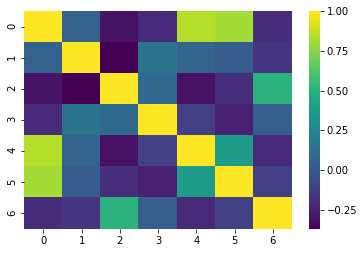

In [384]:
## Covariance analysis
cov = graph_data[['fam_size','Pclass','Age','Sex','SibSp','Parch','Title']].dropna()
cov = (cov - cov.mean())/cov.std()
cov = np.array(cov).T@np.array(cov)/len(cov)
sns.heatmap(cov, cmap = "viridis")

This suggests fam_size, SibSp and Parch are all relatively well correlated. Age and Sex are not particularly well correlated, so should be included on their own.
Title adds information: it is not well correlated with anything except Age.
Generally, the signals are not particularly highly correlated which is reassuring

Based on the number of NaNs, we can also assess to see if that impacts survival

In [385]:
all_data[all_data['data_type']=="train"][['Survived','age_is_nan']].groupby("age_is_nan").mean()

,Survived
age_is_nan,
0,0.406162
1,0.293785


In [386]:
all_data['Survived'].corr(all_data['fam_size'])

0.016638989282745265

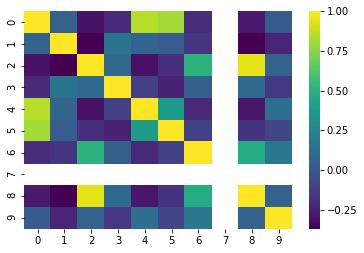

In [388]:
## Covariance analysis
cov = graph_data[['fam_size','Pclass','Age','Sex','SibSp','Parch','Title','age_is_nan','AgeBand','is_alone']].dropna()
cov = (cov - cov.mean())/cov.std()
cov = np.array(cov).T@np.array(cov)/len(cov)
sns.heatmap(cov, cmap = "viridis")

Again, we see this variable has a relatively low correlation with other vars and some correlation with the outcome variable 

In [369]:
rider = graph_data[['Survived','AgeBand','Age','is']].dropna()
np.abs(rider['Survived'].corr(rider['Age'])) - np.abs(rider['Survived'].corr(rider['AgeBand']))

0.009511867407767521

This shows that actually, while age and ageband are highly correlated, there is actually more correlation between age and survived than there is between ageband and survived. Hence, there is no reason to have ageband.

In [421]:
x_vars

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_edit']

In [422]:
y_vars = ['Survived']

In [423]:
train_data_copy = train_data_copy[x_vars + y_vars]

In [424]:
train_data_copy.isna().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      2
Cabin_edit    0
Survived      0
dtype: int64

In [425]:
train_data_copy  = train_data_copy.dropna()

### Train models

In [426]:
from sklearn import model_selection 
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier 
import pandas as pd 
  
# load the data 

X = np.array(train_data_copy[x_vars])
Y = np.array(train_data_copy[y_vars])
#Y = np.reshape(Y,newshape = (len(Y),1))
  
seed = 8
kfold = model_selection.KFold(n_splits = 10, 
                       random_state = seed) 
  
# initialize the base classifier 
base_cls = DecisionTreeClassifier(min_samples_split = 10) 
  
# no. of base classifier 
num_trees = 700
  
# bagging classifier 
model = BaggingClassifier(base_estimator = base_cls, 
                          n_estimators = num_trees, 
                          random_state = seed,
                         max_samples = round(len(train_data_copy)/1.3),
                         bootstrap = True)
fit = model.fit(X,Y)
  
results = model_selection.cross_val_score(model, X, Y, cv = kfold) 
print("accuracy :") 
print(results.mean()) 

C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hugo.lu\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

accuracy :
0.8200842696629213


In [427]:
predictions_train = ((fit.predict(X)))
output = pd.DataFrame()
output['y_hat'] = predictions_train
output['y'] = Y
output['true_positives'] = None
output.at[(output['y'] ==1) & (output['y_hat']==1),'true_positives'] = 1
output['true_negatives'] = None
output.at[(output['y'] ==0) & (output['y_hat']==0),'true_negatives'] = 1
output['false_positives'] = None
output.at[(output['y'] ==0) & (output['y_hat']==1),'false_positives'] = 1
output['false_negatives'] = None
output.at[(output['y'] ==1) & (output['y_hat']==0),'false_negatives'] = 1

In [428]:
output.sum()

y_hat              305.0
y                  340.0
true_positives     281.0
true_negatives     525.0
false_positives     24.0
false_negatives     59.0
dtype: float64

In [429]:
output.sum()
print("the true positive rate is:"+str(output['true_positives'].sum()/output['y_hat'].sum()))

the true positive rate is:0.921311475409836


In [430]:
print("the accuracy rate on the train is:"+str((output['true_negatives'].sum()+output['true_positives'].sum())/len(output)))

the accuracy rate on the train is:0.906636670416198


## Testing the model

#### Cleaning the test set

In [431]:
test_data_copy = test_data.copy(deep = True)
test_data_copy['Survived'] = None
test_data_copy = test_data_copy.reset_index()

In [432]:
test_data_copy = make_bool(test_data_copy,bool_converts) 

[None]
0
None
[3, 2, 1]
0
3
1
2
2
1
['male', 'female']
0
male
1
female
[nan, 'B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78', 'D34', 'D19', 'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61', 'C53', 'D43', 'C130', 'C132', 'C101', 'C55 C57', 'B71', 'C46', 'C116', 'F', 'A29', 'G6', 'C6', 'C28', 'C51', 'E46', 'C54', 'C97', 'D22', 'B10', 'F4', 'E45', 'E52', 'D30', 'B58 B60', 'E34', 'C62 C64', 'A11', 'B11', 'C80', 'F33', 'C85', 'D37', 'C86', 'D21', 'C89', 'F E46', 'A34', 'D', 'B26', 'C22 C26', 'B69', 'C32', 'B78', 'F E57', 'F2', 'A18', 'C106', 'B51 B53 B55', 'D10 D12', 'E60', 'E50', 'E39 E41', 'B52 B54 B56', 'C39', 'B24', 'D28', 'B41', 'C7', 'D40', 'D38', 'C105']
0
nan
1
B45
2
E31
3
B57 B59 B63 B66
4
B36
5
A21
6
C78
7
D34
8
D19
9
A9
10
D15
11
C31
12
C23 C25 C27
13
F G63
14
B61
15
C53
16
D43
17
C130
18
C132
19
C101
20
C55 C57
21
B71
22
C46
23
C116
24
F
25
A29
26
G6
27
C6
28
C28
29
C51
30
E46
31
C54
32
C97
33
D22
34
B10
35
F4
36
E45
37
E52
38
D30
39
B58 B60
40
E34
41
C62 C64
42
A11
43
B11

In [433]:
test_data_copy = remove_nans(test_data_copy,"Age","kde")
test_data_copy['Cabin_edit'] = test_data_copy['Cabin'].apply(lambda x: 1 if np.isnan(x)else 0)

86
86


In [434]:
test_data_copy = test_data_copy[x_vars+y_vars]

In [435]:
test_data_copy.isna().sum()

Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            1
Embarked        0
Cabin_edit      0
Survived      418
dtype: int64

In [436]:
test_data_copy.at[test_data_copy['Fare'].isna(),'Fare'] = test_data_copy['Fare'].mean()

In [437]:
test_data_copy.isna().sum()

Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Cabin_edit      0
Survived      418
dtype: int64

In [438]:
X_test = test_data_copy[x_vars]

### Fit predictions

In [439]:
predictions_test = ((fit.predict(X_test)))
output = pd.DataFrame()
test_data_copy['Survived'] = predictions_test
#output['y'] = Y


In [445]:
output = test_data.copy(deep = True)
output['Survived'] = test_data_copy['Survived']

In [449]:
output = output[['PassengerId','Survived']]

### Save data

In [453]:
pd.DataFrame.to_csv(output,index = False,path_or_buf = r"C:\Users\hugo.lu\repos\repos_backup\Kaggles\1. Titanic\submission.csv")